In [1]:
import numpy as np
import gwpy
import bilby
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
import matplotlib.pyplot as plt
import gwpy.timeseries
%matplotlib inline

# Inject a power spectrum into real data

### The signal to inject: the simulator module takes a gwpy FrequencySeries as input. We start by building a custom input signal by defining an Intensity function. 

In [2]:
frequencies_x = np.linspace(0, 1000, 10000)

alpha1 = 6
alpha2 = 2/3
fref = 20
omegaRef = 1.e-3

def IntensityGW(freqs, omegaRef, alpha1, fref, alpha2 = 2/3):
    ''' GW Intensity function from broken power law in OmegaGW '''
    '''
    
    PARAMETERS
    freqs: np.array
        frequency array
    fref: 
        reference frequency
    omegaRef: 
        Value of OmegaGW at reference frequency
    alpha1:
        first spectral index
    alpha2:
        second spectral index
        
    RETURN
    FrequencySeries
    
    '''
    from pygwb.constants import H0
    H_theor = (3 * H0 ** 2) / (10 * np.pi ** 2)
    
    fknee = fref
    
    power = np.zeros_like(freqs)
    
    power[freqs<fknee] = H_theor * omegaRef * (freqs[freqs<fknee]) ** (alpha1 -3) * fref**(-alpha1)
    power[freqs>fknee] = H_theor * omegaRef * (freqs[freqs>fknee]) ** (alpha2 - 3) * fref**(-alpha2)
    power[freqs==fknee] = H_theor * omegaRef * (fknee) ** (alpha2 -3) * fref**(-alpha2)
    
    #power[freqs<10.]= omegaRef * (10. / fref) ** alpha1
    power[0] = power[1]
    
    return gwpy.frequencyseries.FrequencySeries(power, frequencies=freqs)

Intensity_GW_inject = IntensityGW(frequencies_x, omegaRef = omegaRef, alpha1 = alpha1, fref = fref)

## Create a network of two interferometers

### Using the parameters module, the parameters are loaded up, including the GPS times used to retrieve real data

In [22]:
params = Parameters()
params.update_from_file(path="../test/test_data/parameters_baseline_test.ini")
params.t0=1247644204
params.tf=1247645100
params.segment_duration=128

In [23]:
H1 = Interferometer.from_parameters(params.interferometer_list[0], params)
L1 = Interferometer.from_parameters(params.interferometer_list[1], params)

ifo_list = [H1, L1]

In [24]:
for ifo in ifo_list:
    ifo.sampling_frequency = params.new_sample_rate
    ifo.set_strain_data_from_gwpy_timeseries(gwpy.timeseries.TimeSeries(data=ifo.timeseries.value, times=ifo.timeseries.times))
    ifo.duration=params.segment_duration

### Create baseline and network

In [25]:
HL_baseline = Baseline.from_parameters(H1, L1, params)

In [26]:
net_HL = Network.from_baselines("HL_network", [HL_baseline])

### Visualize a minute of data

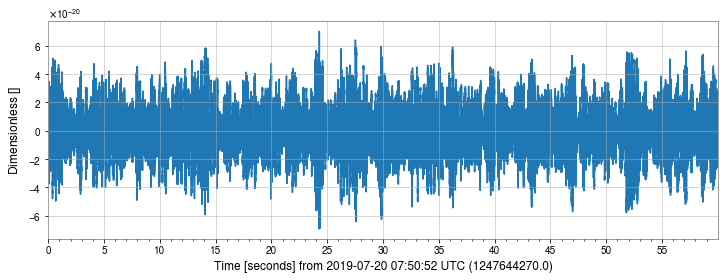

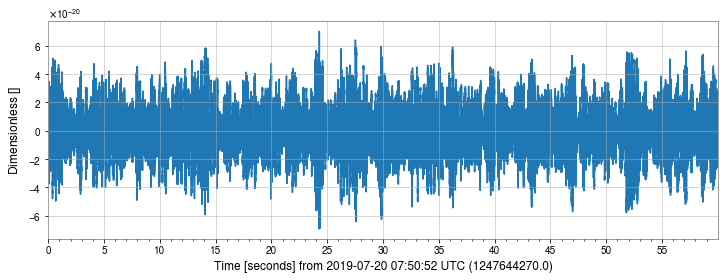

In [27]:
crop_start_time = net_HL.interferometers[0].strain_data.start_time
crop_duration   = 60

# Note: we need to grab the TimeSeries from the bilby interferometer, which requires converting it to a TimeSeries
data_H_1min_pre_injection = net_HL.interferometers[0].strain_data.to_gwpy_timeseries().crop(start = crop_start_time, end = crop_start_time + crop_duration)
data_H_1min_pre_injection.plot()

Text(0, 0.5, 'PSD')

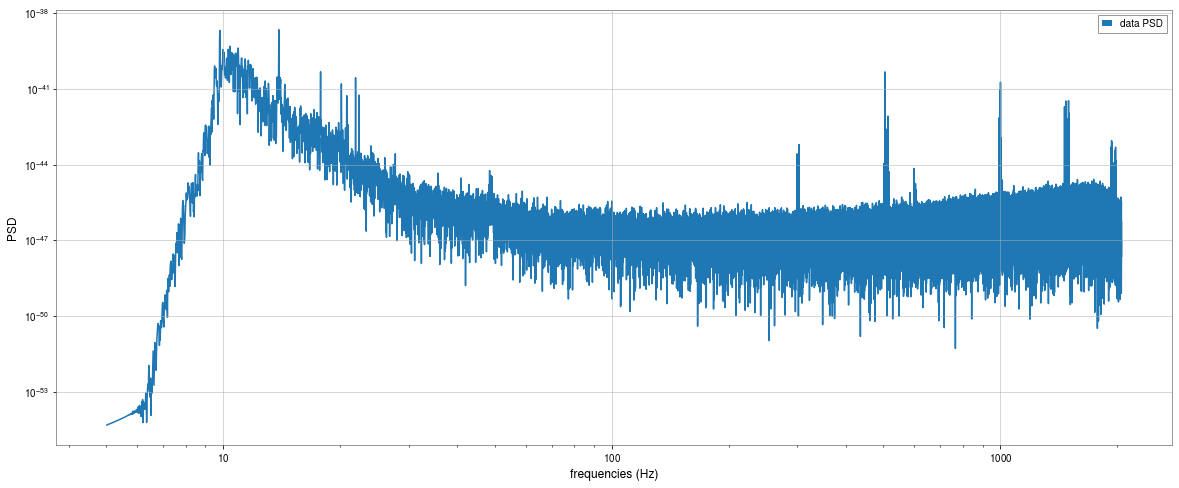

In [28]:
frequencies = data_H_1min_pre_injection.psd().frequencies.value

mask = frequencies>5.

ax, fig = plt.subplots(figsize = (20,8))
plt.loglog(frequencies[mask], data_H_1min_pre_injection.psd().value[mask], label = 'data PSD')
plt.legend()
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')

## Inject simulated data on top of the ereal data -- this uses the simulator module

In [29]:
net_HL.set_interferometer_data_from_simulator(Intensity_GW_inject, N_segments=7,  sampling_frequency=H1.sampling_frequency, inject_into_data_flag=True)

2022-04-25 02:32:01.597 | INFO     | pygwb.simulator:generate_data:216 - Adding data to channel H1:SIM-STOCH_INJ
2022-04-25 02:32:02.075 | INFO     | pygwb.simulator:generate_data:216 - Adding data to channel L1:SIM-STOCH_INJ


### Visualise a minute of data

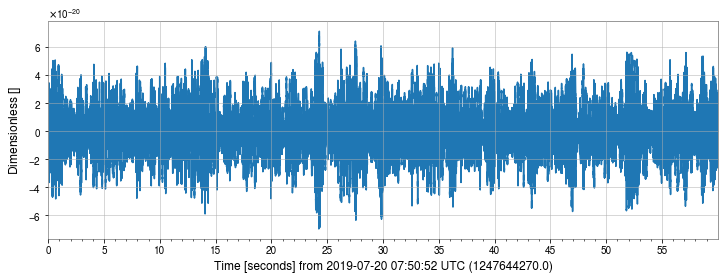

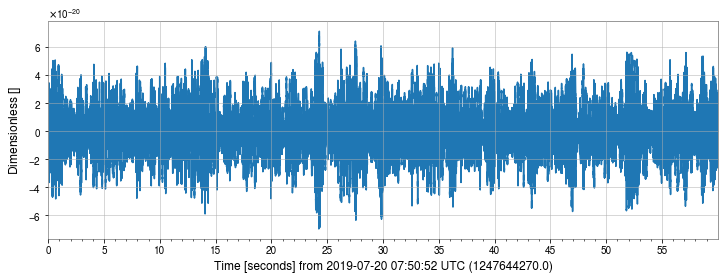

In [30]:
crop_start_time = net_HL.interferometers[0].strain_data.start_time
crop_duration   = 60

# Note: we need to grab the TimeSeries from the bilby interferometer, which requires converting it to a TimeSeries
data_H_1min_post_injection = net_HL.interferometers[0].strain_data.to_gwpy_timeseries().crop(start = crop_start_time, end = crop_start_time + crop_duration)
data_H_1min_post_injection.plot()

### Optional: one may save the data by calling save_interferometer_data_to_file and specifying the file format as an argument. This wraps gwpy.TimeSeries.write()

In [ ]:
# net_HL.save_interferometer_data_to_file()

### Visualize the data PSD, both before and after the injection on top of real data

Text(0, 0.5, 'PSD')

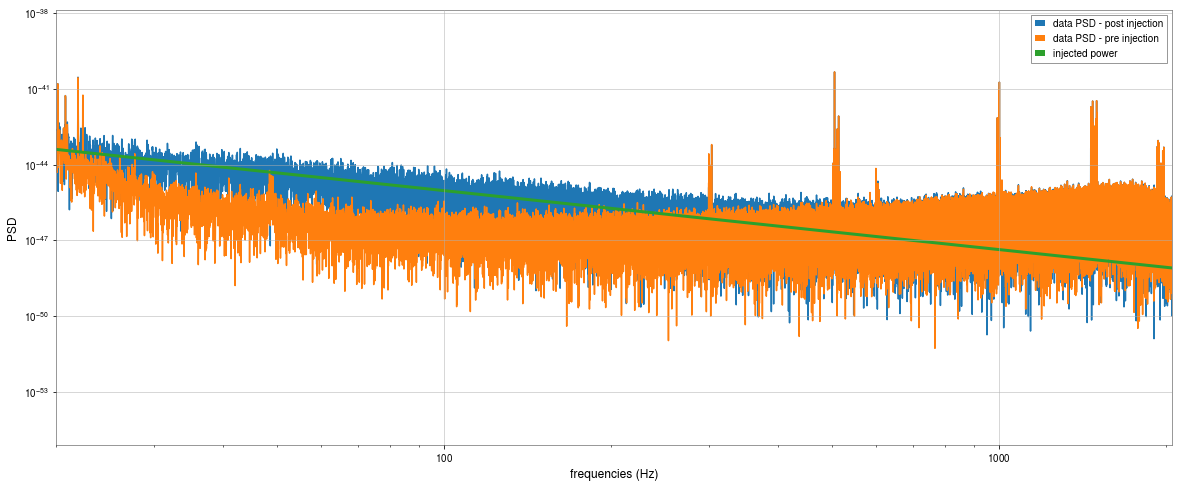

In [31]:
frequencies = data_H_1min_post_injection.psd().frequencies.value

mask = frequencies>5.

ax, fig = plt.subplots(figsize = (20,8))
plt.loglog(frequencies[mask], data_H_1min_post_injection.psd().value[mask], label = 'data PSD - post injection')
plt.loglog(frequencies[mask], data_H_1min_pre_injection.psd().value[mask], label = 'data PSD - pre injection')


plt.loglog(frequencies[mask], IntensityGW(frequencies[mask],omegaRef = omegaRef, alpha1 = alpha1, fref = fref), linewidth = 3, label = 'injected power')
plt.legend()
plt.xlim(20,frequencies[-1])
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')